# Part 2 - Other features analysis

## ..

### Installation

In [ ]:
#pip install statsmodels

In [1]:
#pip install torch

In [2]:
#pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#pip install requests

In [2]:
#pip install matplotlib

In [4]:
#pip install scikit-learn

In [5]:
#pip install keras

Note: you may need to restart the kernel to use updated packages.


### Importing packages

In [1]:
# Import packages
import json
import csv
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

### OTHER

#### *100m sprint*

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page to scrape
url = "https://worldathletics.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior"

# Send a request to fetch the page content
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Parse the page content
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table containing the data
table = soup.find('table')

# Extract table headers
headers = [header.text.strip() for header in table.find_all('th')]

# Extract table rows
rows = []
for row in table.find_all('tr')[1:]:  # Skip the header row
    columns = row.find_all('td')
    row_data = [col.text.strip() for col in columns]
    rows.append(row_data)

# Create a DataFrame
df = pd.DataFrame(rows, columns=headers)

# Save the data to a CSV file
df.to_csv('100m_sprint_all_time_toplist.csv', index=False)

print("Data has been saved to 100m_sprint_all_time_toplist.csv")


Data has been saved to 100m_sprint_all_time_toplist.csv


In [2]:
df

,Rank,Mark,WIND,Competitor,DOB,Nat,Pos,,Venue,Date,Results Score
0,1,9.58,+0.9,Usain BOLT,21 AUG 1986,JAM,1,,"Olympiastadion, Berlin (GER)",16 AUG 2009,1356
1,2,9.69,+2.0,Tyson GAY,09 AUG 1982,USA,1,,Shanghai (CHN),20 SEP 2009,1316
2,2,9.69,-0.1,Yohan BLAKE,26 DEC 1989,JAM,1,,"Stade Olympique de la Pontaise, Lausanne (SUI)",23 AUG 2012,1316
3,4,9.72,+0.2,Asafa POWELL,23 NOV 1982,JAM,1f1,,"Stade Olympique de la Pontaise, Lausanne (SUI)",02 SEP 2008,1305
4,5,9.74,+0.9,Justin GATLIN,10 FEB 1982,USA,1,,"Suhaim bin Hamad Stadium, Doha (QAT)",15 MAY 2015,1298
...,...,...,...,...,...,...,...,...,...,...,...
95,95,9.94,-0.2,Bernard WILLIAMS,19 JAN 1978,USA,2,,"Commonwealth Stadium, Edmonton (CAN)",05 AUG 2001,1228
96,95,9.94,+1.7,Diondre BATSON,13 JUL 1992,USA,2h2,,"Hayward Field, Eugene, OR (USA)",25 JUN 2015,1227
97,95,9.94,+1.4,Andrew FISHER,15 DEC 1991,JAM,2,,"Moratalaz, Madrid (ESP)",11 JUL 2015,1227
98,95,9.94,+1.0,Ameer WEBB,19 MAR 1991,USA,2f1,,"Stadio Olimpico, Roma (ITA)",02 JUN 2016,1227


We now have created a dataframe and saved it in a csv file. This gives us informations about the 100 first athletes for the 100m sprint in the world.

We have 11 columns:
- ID
- Rank
- Mark
- WIND
- Competitor (the name and surname of the athlete)
- DOB (the date of birth)
- NAT (nationality)
- Pos (I don't know yet)
- Venue (The venue in which he made his best time)
- Date (the date he made his best time)
- Result score

We ideally want to have more information about each individual athlete. To do that, another page of this website has access to their profile page. We need to get access to it doing once again webscrapping.

## Data collection

Web scrapping with *beautifulsoup4* from the website https://worldathletics.org/world-rankings/5000m/men?regionType=world&page=1&rankDate=2024-06-04&limitByCountry=0

#### *5000m*

In [2]:
#pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


Import packages

Create and define functions

In [3]:
# Function to fetch athlete profile URLs and nationalities
def fetch_profile_urls():
    url = "https://worldathletics.org/world-rankings/5000m/men?regionType=world&page=1&rankDate=2024-06-04&limitByCountry=0"
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful

    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all table rows containing athlete data
    athlete_rows = soup.find_all('tr', class_='table-row--hover')

    athletes = {}
    for row in athlete_rows:
        name_element = row.find('td', {'data-th': 'Competitor'})
        if name_element:
            name = name_element.text.strip()
            profile_url = "https://worldathletics.org" + row['data-athlete-url']
            nationality_element = row.find('td', {'data-th': 'Nat'})
            if nationality_element:
                nationality = nationality_element.text.strip()
            else:
                nationality = ""
            athletes[name] = {'profile_url': profile_url, 'nationality': nationality}

    return athletes

In [4]:
# Function to recursively search for 5000 meters results
def search_5000m_results(node, results):
    if isinstance(node, dict):
        for key, value in node.items():
            if isinstance(value, list) or isinstance(value, dict):
                search_5000m_results(value, results)
            elif key == 'discipline' and '5000 Metres' in value:
                results.append(node)
    elif isinstance(node, list):
        for item in node:
            if isinstance(item, list) or isinstance(item, dict):
                search_5000m_results(item, results)


# Function to extract 5000m results for a given athlete URL
def extract_5000m_results(url):
    # Fetch the HTML content of the page
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful
    html_content = response.text

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the <script> tag with id="__NEXT_DATA__" and type="application/json"
    script_tag = soup.find('script', {'id': '__NEXT_DATA__', 'type': 'application/json'})

    # Extract the JSON content from the <script> tag
    json_content = script_tag.string

    # Parse the JSON content
    data = json.loads(json_content)

    # Extract 5000 meters results
    results_5000m = []
    search_5000m_results(data, results_5000m)

    return results_5000m


In [5]:
# Function to extract relevant data
def extract_5000m_data(athlete, nationality, results):
    for result in results:
        # Check if this is a progression result with multiple results
        if 'results' in result:
            for progression in result['results']:
                rows.append({
                    'Athlete': athlete,
                    'Nationality': nationality,
                    'Score': progression.get('resultScore', ''),
                    'Date': progression.get('date', ''),
                    'Venue': progression.get('venue', ''),
                    'Place': progression.get('place', '')  # Use 'listPosition' instead of 'place'
                })
        else:
            rows.append({
                'Athlete': athlete,
                'Nationality': nationality,
                'Score': result.get('resultScore', ''),
                'Date': result.get('date', ''),
                'Venue': result.get('venue', ''),
                'Place': result.get('place', '')  # Use 'listPosition' instead of 'place'
            })

Create a dataset in a data frame and csv format.

In [6]:
# Fetch athlete profile URLs
athletes = fetch_profile_urls()

# List to hold all extracted rows
all_rows = []

# Loop through each athlete and extract their 5000m results
for athlete, data in athletes.items():
    athlete_url = data['profile_url']
    nationality = data['nationality']
    #print(f"Extracting 5000m results for {athlete}...")
    athlete_results = extract_5000m_results(athlete_url)
    
    # List to hold the extracted rows for this athlete
    rows = []
    # Extract data for this athlete
    extract_5000m_data(athlete, nationality, athlete_results)
    # Add rows for this athlete to the list of all rows
    all_rows.extend(rows)

# Define CSV file name
csv_file_name = '5000m_results_with_urls.csv'

# Write all rows to CSV
with open(csv_file_name, 'w', newline='') as csv_file:
    fieldnames = ['Athlete', 'Nationality', 'Score', 'Date', 'Venue', 'Place']  # Add 'Athlete' field
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for row in all_rows:
        writer.writerow(row)

print(f"Data successfully written to {csv_file_name}")

KeyboardInterrupt: 

## Preprocessing the data

### Put the right type of attribute to each variable, drop NA values 

In [37]:
df_5000m = pd.read_csv("5000m_results_with_urls.csv")
print(df_5000m.head())
print(df_5000m.info())

          Athlete Nationality   Score         Date  \
0  Yomif KEJELCHA         ETH  1288.0  30 MAY 2024   
1  Yomif KEJELCHA         ETH  1288.0  30 MAY 2024   
2  Yomif KEJELCHA         ETH  1119.0  25 JUL 2014   
3  Yomif KEJELCHA         ETH  1232.0  11 SEP 2015   
4  Yomif KEJELCHA         ETH  1198.0  14 MAY 2016   

                               Venue  Place  
0        Bislett Stadion, Oslo (NOR)    NaN  
1        Bislett Stadion, Oslo (NOR)    NaN  
2    Hayward Field, Eugene, OR (USA)    NaN  
3  Boudewijnstadion, Bruxelles (BEL)    NaN  
4   Shanghai Stadium, Shanghai (CHN)    NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Athlete      3982 non-null   object 
 1   Nationality  3982 non-null   object 
 2   Score        1645 non-null   float64
 3   Date         2875 non-null   object 
 4   Venue        2875 non-null   object 

In [38]:
# Counting null values per column
null_counts = df_5000m.isnull().sum()
print("Number of null values per column:")
print(null_counts)

Number of null values per column:
Athlete           0
Nationality       0
Score          2337
Date           1107
Venue          1107
Place          2514
dtype: int64


In [39]:
# Removing rows with null 'Venue' & removing duplicates
df_5000m_cleaned0 = df_5000m.dropna(subset=['Venue', 'Score'])
df_5000m_cleaned1 = df_5000m_cleaned0.drop_duplicates()
df_5000m_cleaned2 = df_5000m_cleaned1.dropna(subset=['Place', 'Score'], how='all')

In [40]:
null_counts = df_5000m_cleaned2.isnull().sum()
print("Number of null values per column:")
print(null_counts)

Number of null values per column:
Athlete          0
Nationality      0
Score            0
Date             0
Venue            0
Place          796
dtype: int64


Now that we have removed all of the rows with NA venue, and all of the rows where either `place`, `score` or both were empty, we need to assign the right type for each variable.

The 5 differents variables are: 
- Athlete: object into character or factor
- Score: float
- Data: object to convert into datetime
- Venue: object into character or factor or to dertermine
- Place: float to convert into nummerical

In [41]:
df = df_5000m_cleaned2
df.loc[:, 'Athlete'] = pd.Categorical(df['Athlete'])
df.loc[:, 'Nationality'] = pd.Categorical(df['Nationality'])
df['Date'] = pd.to_datetime(df['Date'], format='%d %b %Y', errors='coerce')
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
print(df.head())
print(df.info())

          Athlete Nationality   Score       Date  \
0  Yomif KEJELCHA         ETH  1288.0 2024-05-30   
2  Yomif KEJELCHA         ETH  1119.0 2014-07-25   
3  Yomif KEJELCHA         ETH  1232.0 2015-09-11   
4  Yomif KEJELCHA         ETH  1198.0 2016-05-14   
5  Yomif KEJELCHA         ETH  1205.0 2017-05-27   

                               Venue  Place  Day  Month  Year  
0        Bislett Stadion, Oslo (NOR)    NaN   30      5  2024  
2    Hayward Field, Eugene, OR (USA)    NaN   25      7  2014  
3  Boudewijnstadion, Bruxelles (BEL)    NaN   11      9  2015  
4   Shanghai Stadium, Shanghai (CHN)    NaN   14      5  2016  
5    Hayward Field, Eugene, OR (USA)    NaN   27      5  2017  
<class 'pandas.core.frame.DataFrame'>
Index: 1056 entries, 0 to 3966
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Athlete      1056 non-null   object        
 1   Nationality  1056 non-null   object        
 2   S

### Data simulation

While reading articles on the sport's prediction, we wanted to ackknowledge the fact that we have to take into account several other parameters than past perfromances. We chose sujbectively to implement the effect of crow cheering on athletes as well as the environmental change. 
- `CrowdCheeringEffect`: the biggest number means = the biggest advantage.
- `EnvironmentalAdaptation`: the biggest number = the biggest advantage.

For example, a French athlete woould have a bigger CrowdCheeringEffect score than a Australian because these Olympic Games are located in France this year. 
Another example would be that an American would have a bigger EnvironmentalAdaptation Score than an African athlete, for example Ethiopian, as the cultural difference is way more pronouced between Ethiopia and France than USA and France.

In [42]:
# Define factors for distance from France, climate similarity, and cultural/travel ease for each country
### WE COULD AUTOMATE THIS
distance_factor = {
    'ETH': 0.5, 'USA': 0.7, 'AUS': 0.9, 'NOR': 0.2, 'GER': 0.1, 'FRA': 0.0, 
    'KEN': 0.5, 'ESP': 0.1, 'GBR': 0.1, 'CAN': 0.6, 'UGA': 0.5, 'SUI': 0.1, 
    'BEL': 0.1, 'JPN': 0.8, 'NED': 0.1, 'IRL': 0.2, 'SWE': 0.2, 'BRN': 0.7, 
    'ITA': 0.1, 'RUS': 0.4, 'GUA': 0.8, 'BDI': 0.5, 'SRB': 0.3, 'RSA': 0.6, 
    'THA': 0.8, 'ERI': 0.5, 'AUT': 0.1, 'DJI': 0.6, 'IND': 0.7, 'URU': 0.8, 'MAR': 0.2
}

climate_factor = {
    'ETH': 0.4, 'USA': 0.6, 'AUS': 0.6, 'NOR': 0.7, 'GER': 0.9, 'FRA': 1.0, 
    'KEN': 0.4, 'ESP': 0.8, 'GBR': 0.8, 'CAN': 0.6, 'UGA': 0.4, 'SUI': 0.9, 
    'BEL': 0.8, 'JPN': 0.6, 'NED': 0.8, 'IRL': 0.8, 'SWE': 0.7, 'BRN': 0.4, 
    'ITA': 0.9, 'RUS': 0.6, 'GUA': 0.3, 'BDI': 0.4, 'SRB': 0.7, 'RSA': 0.5, 
    'THA': 0.3, 'ERI': 0.4, 'AUT': 0.9, 'DJI': 0.4, 'IND': 0.4, 'URU': 0.4, 'MAR': 0.8
}

cultural_factor = {
    'ETH': 0.4, 'USA': 0.7, 'AUS': 0.6, 'NOR': 0.8, 'GER': 0.9, 'FRA': 1.0, 
    'KEN': 0.4, 'ESP': 0.9, 'GBR': 0.9, 'CAN': 0.7, 'UGA': 0.4, 'SUI': 0.9, 
    'BEL': 0.9, 'JPN': 0.6, 'NED': 0.9, 'IRL': 0.8, 'SWE': 0.8, 'BRN': 0.4, 
    'ITA': 0.9, 'RUS': 0.6, 'GUA': 0.3, 'BDI': 0.4, 'SRB': 0.7, 'RSA': 0.4, 
    'THA': 0.3, 'ERI': 0.4, 'AUT': 0.9, 'DJI': 0.3, 'IND': 0.3, 'URU': 0.3, 'MAR': 0.8
}

# Define initial count of athletes per nationality
initial_nationalities = {
    'ETH': 0, 'USA': 0, 'AUS': 0, 'NOR': 0, 'GER': 0, 'FRA': 0, 
    'KEN': 0, 'ESP': 0, 'GBR': 0, 'CAN': 0, 'UGA': 0, 'SUI': 0, 
    'BEL': 0, 'JPN': 0, 'NED': 0, 'IRL': 0, 'SWE': 0, 'BRN': 0, 
    'ITA': 0, 'RUS': 0, 'GUA': 0, 'BDI': 0, 'SRB': 0, 'RSA': 0, 
    'THA': 0, 'ERI': 0, 'AUT': 0, 'DJI': 0, 'IND': 0, 'URU': 0, 'MAR': 0
}

In [43]:
# Define the number of simulations
num_simulations = 10000

# Count the number of athletes per nationality
nationalities = df['Nationality'].value_counts().to_dict()

# Function to calculate mean and standard deviation based on factors
def calculate_params(distance, climate, cultural):
    base_mean = 0.10
    base_std = 0.05
    mean_cheering_effect = base_mean + 0.05 * (1 - distance) + 0.05 * cultural
    std_cheering_effect = base_std - 0.01 * cultural
    
    mean_environmental_adaptation = base_mean + 0.05 * climate
    std_environmental_adaptation = base_std - 0.01 * climate
    
    return mean_cheering_effect, std_cheering_effect, mean_environmental_adaptation, std_environmental_adaptation

# Create the params dictionary
params = {}
for nationality in nationalities.keys():
    mean_cheering_effect, std_cheering_effect, mean_environmental_adaptation, std_environmental_adaptation = calculate_params(
        distance_factor.get(nationality, 0), climate_factor.get(nationality, 0), cultural_factor.get(nationality, 0)
    )
    params[nationality] = {
        'mean_cheering_effect': mean_cheering_effect, 'std_cheering_effect': std_cheering_effect,
        'mean_environmental_adaptation': mean_environmental_adaptation, 'std_environmental_adaptation': std_environmental_adaptation
    }

    
# Function to simulate performance for a given nationality
def simulate_performance(nationality, num_athletes):
    mean_cheering_effect = params[nationality]['mean_cheering_effect']
    std_cheering_effect = params[nationality]['std_cheering_effect']
    mean_environmental_adaptation = params[nationality]['mean_environmental_adaptation']
    std_environmental_adaptation = params[nationality]['std_environmental_adaptation']
    
    cheering_effect = np.random.normal(mean_cheering_effect, std_cheering_effect, num_athletes)
    environmental_adaptation = np.random.normal(mean_environmental_adaptation, std_environmental_adaptation, num_athletes)
    
    return cheering_effect, environmental_adaptation

# Initialize lists to store simulated results
cheering_effects = []
environmental_adaptations = []

# Iterate through each unique nationality in the DataFrame
for nationality in df['Nationality'].unique():
    if nationality in nationalities:
        num_athletes = nationalities[nationality]  # Number of athletes for this nationality
        cheering_effect, environmental_adaptation = simulate_performance(nationality, num_athletes)
        
        # Extend lists with simulation results
        cheering_effects.extend(cheering_effect)
        environmental_adaptations.extend(environmental_adaptation)
    else:
        # Handle cases where nationality in df['Nationality'] is not found in nationalities
        print(f"Warning: No athlete count found for nationality '{nationality}'")


In [44]:
# Assign simulated results to DataFrame using .loc to avoid SettingWithCopyWarning
df.loc[:, 'CrowdCheeringEffect'] = cheering_effects[:len(df)]  # Ensure lengths match
df.loc[:, 'EnvironmentalAdaptation'] = environmental_adaptations[:len(df)]  # Ensure lengths match
df.head()

,Athlete,Nationality,Score,Date,Venue,Place,Day,Month,Year,CrowdCheeringEffect,EnvironmentalAdaptation
0,Yomif KEJELCHA,ETH,1288.0,2024-05-30,"Bislett Stadion, Oslo (NOR)",NaN,30,5,2024,0.119978,0.145265
2,Yomif KEJELCHA,ETH,1119.0,2014-07-25,"Hayward Field, Eugene, OR (USA)",NaN,25,7,2014,0.190480,0.120200
3,Yomif KEJELCHA,ETH,1232.0,2015-09-11,"Boudewijnstadion, Bruxelles (BEL)",NaN,11,9,2015,0.114740,0.076000
4,Yomif KEJELCHA,ETH,1198.0,2016-05-14,"Shanghai Stadium, Shanghai (CHN)",NaN,14,5,2016,0.186542,0.099566
5,Yomif KEJELCHA,ETH,1205.0,2017-05-27,"Hayward Field, Eugene, OR (USA)",NaN,27,5,2017,0.205814,0.128483


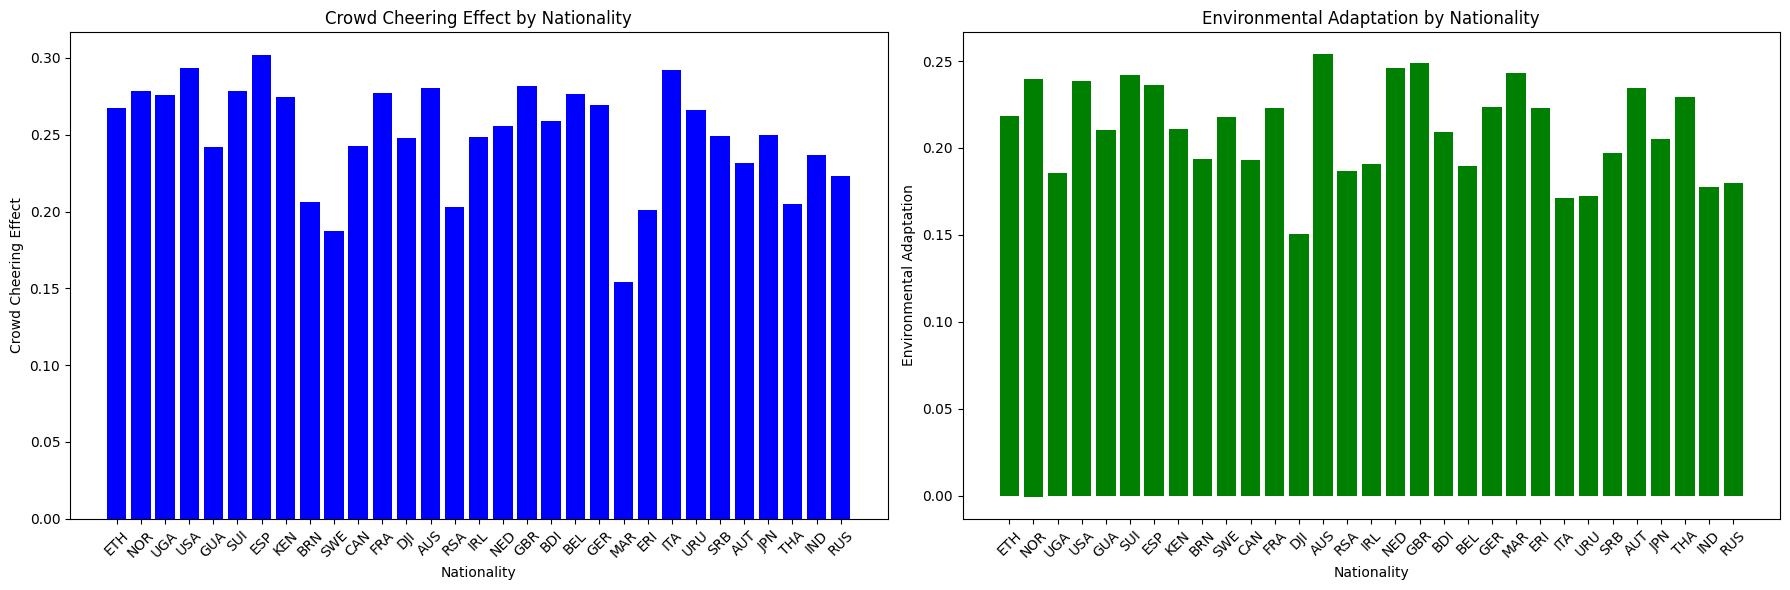

In [45]:
# Set up subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Crowd Cheering Effect by Nationality
axs[0].bar(df['Nationality'], df['CrowdCheeringEffect'], color='blue')
axs[0].set_xlabel('Nationality')
axs[0].set_ylabel('Crowd Cheering Effect')
axs[0].set_title('Crowd Cheering Effect by Nationality')
axs[0].tick_params(axis='x', rotation=45)

# Plot 2: Environmental Adaptation by Nationality
axs[1].bar(df['Nationality'], df['EnvironmentalAdaptation'], color='green')
axs[1].set_xlabel('Nationality')
axs[1].set_ylabel('Environmental Adaptation')
axs[1].set_title('Environmental Adaptation by Nationality')
axs[1].tick_params(axis='x', rotation=45)
# Adjust layout
plt.tight_layout()
plt.show()

ADD COMMENTS HERE

### Catogorical encoding

In [46]:
# Encoding Nationalities
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Nationality_encoded'] = label_encoder.fit_transform(df['Nationality'])
df['Venue_encoded'] = label_encoder.fit_transform(df['Venue'])

Also, we have extracted our data from the official athletics website. The athletes are listed through their rank. 
Let's create a column rank, the first athlete being the first best athlete in the 5000m sprint category, and the last one being the 100th one.

In [47]:
df['Rank'] = label_encoder.fit_transform(df['Athlete'])
df['Rank'] = df['Rank'].max() - df['Rank'] + 1

### Normalise / Standardise nummerical features

The goal is to predict the Score of the athletes in order to get the highest one and to predict the winner of the 5000m sprint at the olympics.

In [48]:
scaler = StandardScaler()
# Score variable
df['Score_std'] = scaler.fit_transform(df[['Score']])

In [49]:
# Creating `features`liste that is going to be our attributes for the prediction of the score 
# Features to be standardized
features = ['Nationality_encoded', 'Venue_encoded', 'Month', 'Year', 'CrowdCheeringEffect', 'EnvironmentalAdaptation']

# Apply the scaler to these features
df[features] = scaler.fit_transform(df[features])


## Data visualisation

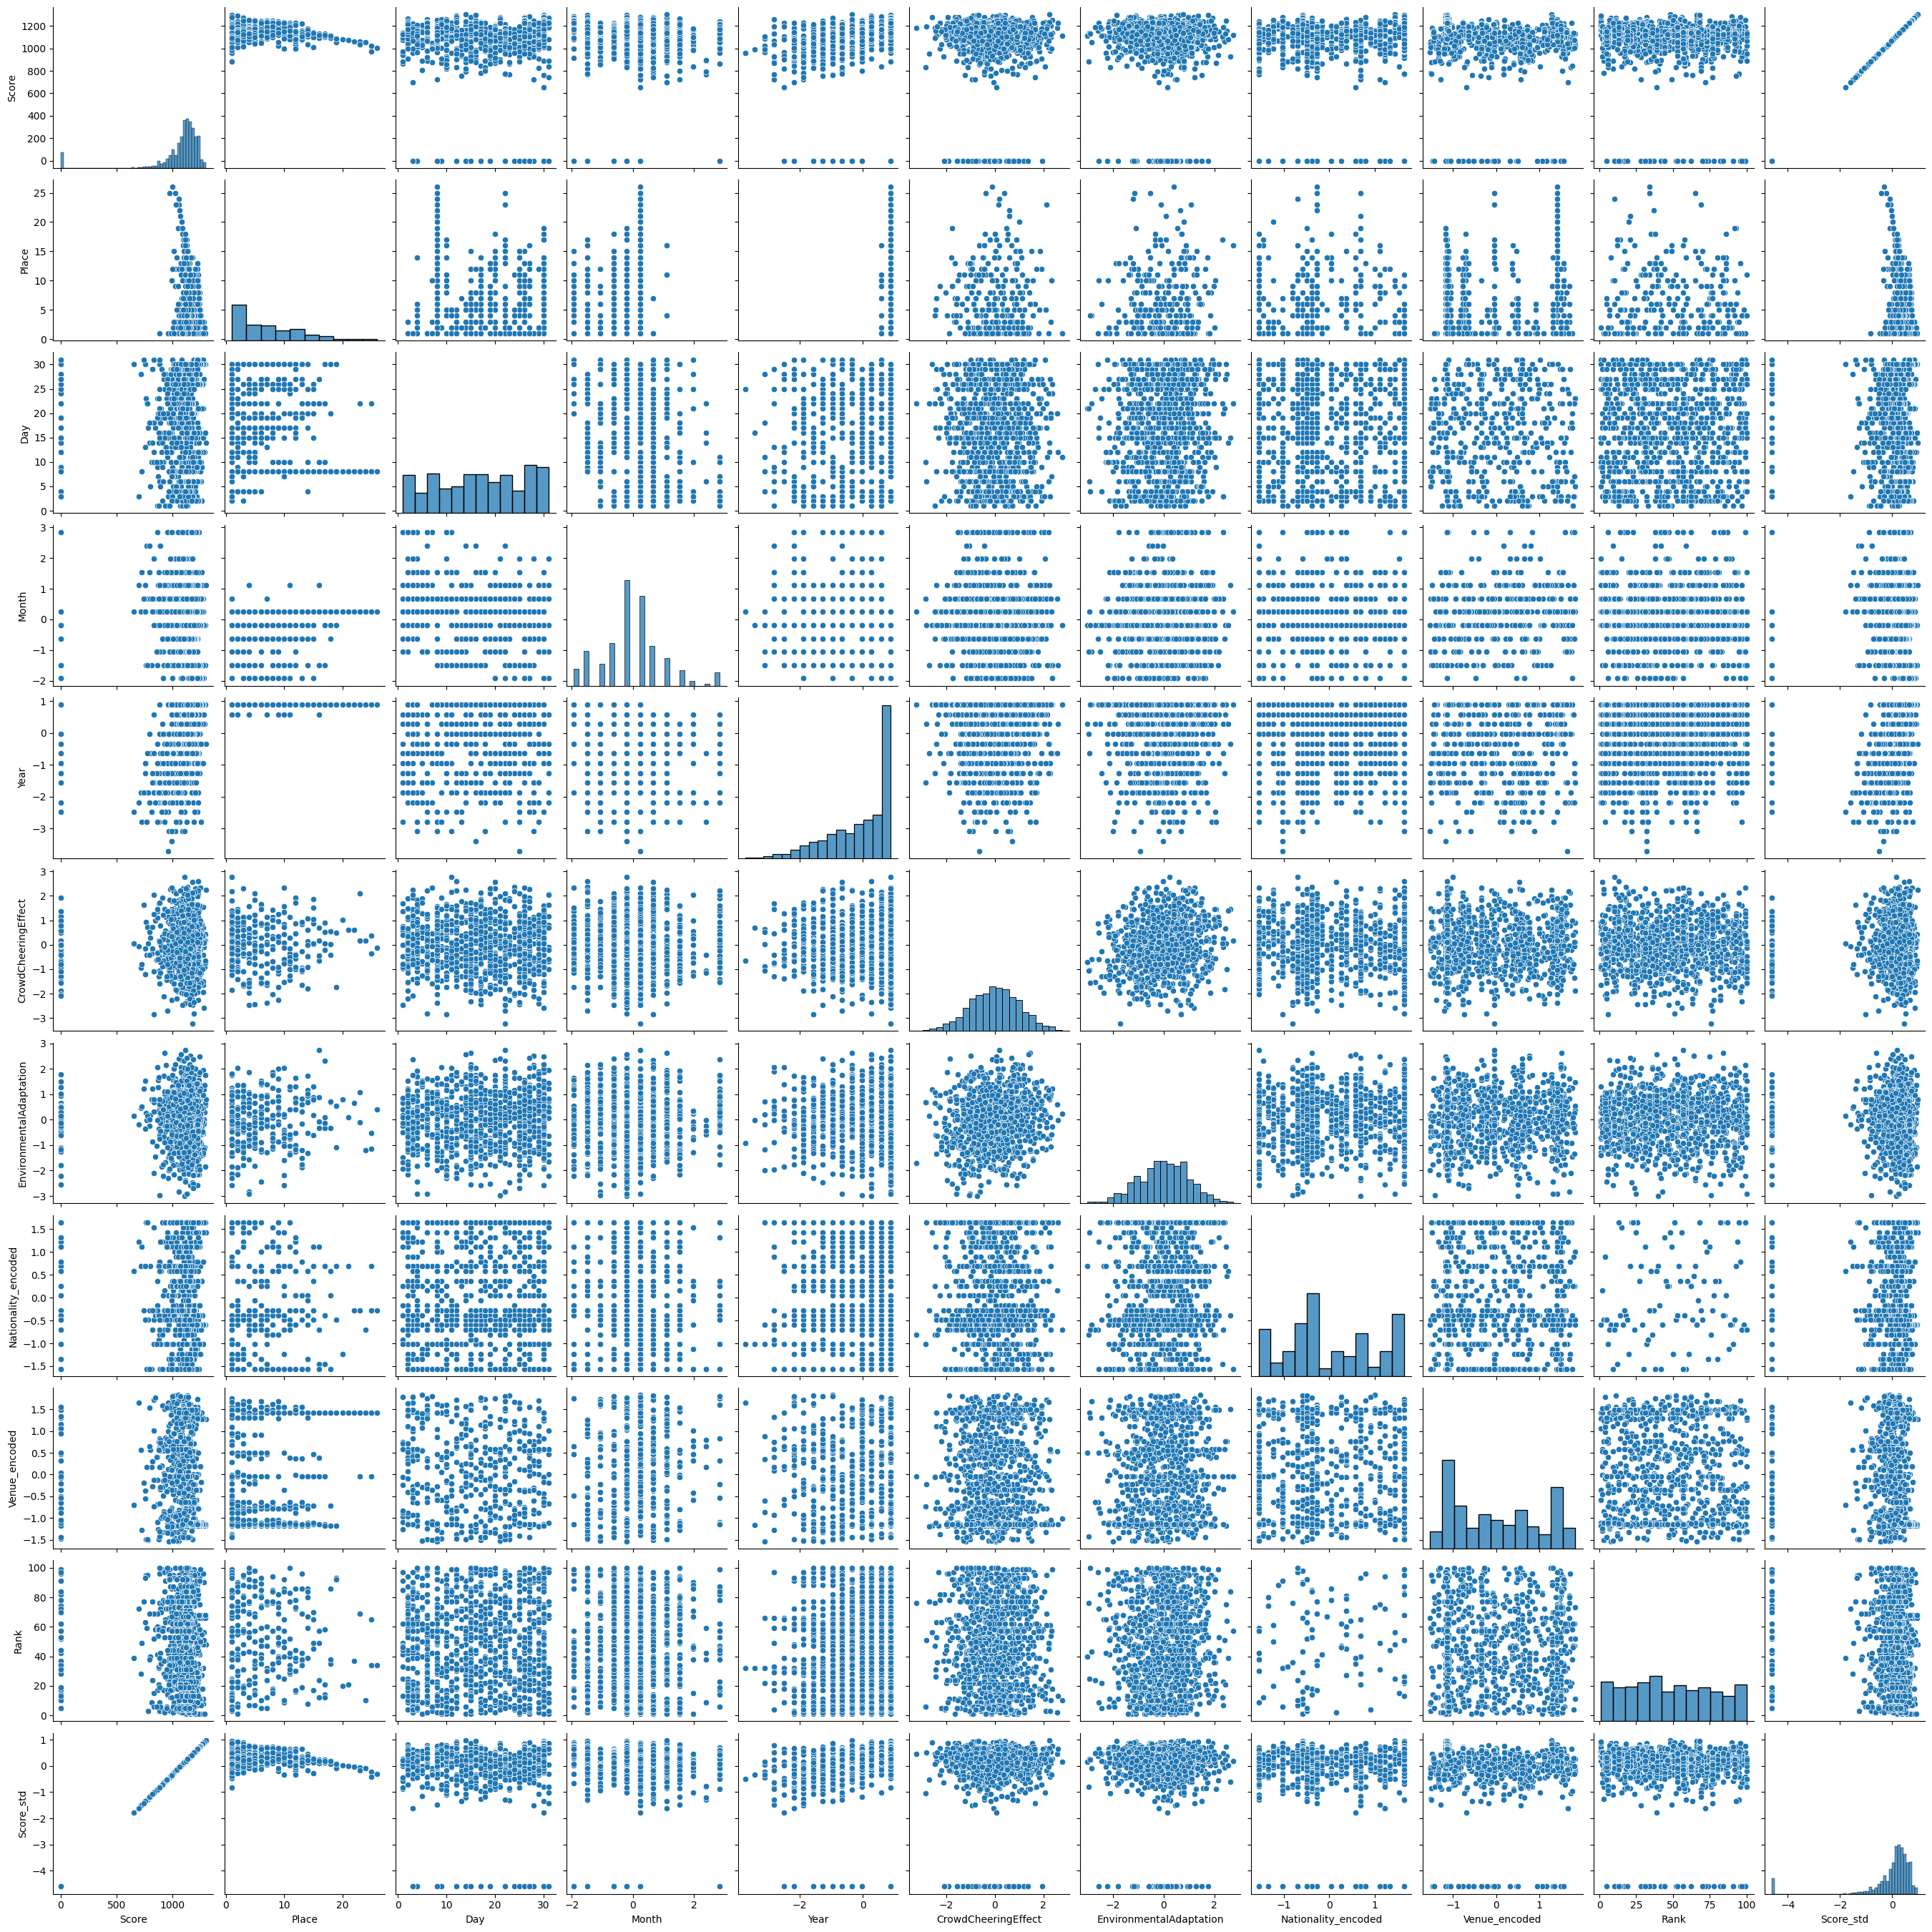

In [50]:
# Create pair plot
sns.pairplot(df)

# Show the plot
plt.show()

ADD COMMENTS

## Label creation

We want to predict the `Score` of each individual. The one with the highest score will be considered as the winner. WE will consider the `Score_std` variable in order to neglect the weight imposed by the high Scores.

## Model

To recall, the goal of our analysis is to predict the Score of each athlete in order to predict the winner of the 5000m sprint at the olympic games in Paris the first week of August.

In order to do that we are going to tackle this problem using 3 methodologies:
- Linear regression

Because it is a regression task, the most common answer would be using Linear Regression. Let's see how it goes.

- Neural Network

We chose this first method because of several paper found on this topic such as (https://dtai.cs.kuleuven.be/events/MLSA17/papers/MLSA17_paper_4.pdf 'An Artifical Neural Netword-based Prediction Model for Underdog Teams in NBA Matches). In these papers the task was classification, so our results cannot be compared with them as ours is a regression task. 

Why use a neural network instead of a basic regression task: to get more informatiosn ADD COMMENTS HERE

- Polynomial regression? 

Because Linear regression is often not the best when used on complex datsets, we might want to use more complex regression models such as Polynomial Regression.

- Random Forest

FIND A REASON WHY, I'M TESTING EVERYTHING AT THIS POINT BECASUE I KNOW THAT THE DATASET IS NOT THE BEST, WE DON'T HAVE ENOUGH INFORMATION. THOUGH I THINK WE CAN IMPROVE IT BY PROCESSING IT A BIT BETTER ######## TO MODIFY ############

In [69]:
from sklearn.model_selection import train_test_split

# Assuming you have all features in the DataFrame and the target is winning_probability
features = ['Nationality_encoded', 'Venue_encoded', 'Month', 'Year', 'CrowdCheeringEffect', 'EnvironmentalAdaptation', 'Rank']
X = df[features]
y = df['Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Regression with Sklearn

#### With Sklearn

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Creqte Linear Regression Model
model_LR = LinearRegression()

In [71]:
# Train the model
model_LR.fit(X_train, y_train)

# Evaluate the model on the training data
train_r2_score = model_LR.score(X_train, y_train)
print(f"Training R-squared value: {train_r2_score}")

# Evaluate the model on the testing data
test_r2_score = model_LR.score(X_test, y_test)
print(f"Testing R-squared value: {test_r2_score}")


Training R-squared value: 0.027651251705051894
Testing R-squared value: 0.025428568638697358


The R-squared value measures how well the linear regression model fits the data, ranging from 0 to 1, where 1 indicates a perfect fit.
Here we can definitely say that the model doesn't fit the data.

In [72]:
# Predict the scores on the testing set
y_pred = model_LR.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Determine the top 10 athletes based on predicted scores
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=X_test.index)

# Sort by predicted score in descending order and get the top 10
top_10_athletes = test_results.sort_values(by='Predicted', ascending=False).head(10)

result_LR = pd.DataFrame(
    {
        "Rank": df.loc[top_10_athletes.index, 'Rank'],
        "Top_10_athlete":  df.loc[top_10_athletes.index, 'Athlete'],
        "Actual score": top_10_athletes['Actual'],
        "Predicted score": top_10_athletes['Predicted']
    }
)
print(result_LR)


Mean Squared Error: 47787.38345831696
      Rank    Top_10_athlete  Actual score  Predicted score
3315    10    Sergio JIMÉNEZ        1109.0      1153.433786
1503    18         Sam ATKIN        1237.0      1150.381638
3709    57     Jackson SHARP        1089.0      1149.469495
2596    42       Ky ROBINSON        1238.0      1149.224567
339     11    Selemon BAREGA        1231.0      1147.660201
2688     6     Thomas FAFARD        1191.0      1135.891142
2880    15  Santiago CATROFE        1096.0      1131.034195
3699    57     Jackson SHARP        1167.0      1130.161059
2307    17       Sam PARSONS        1136.0      1127.818224
1588    49       Jonas RAESS        1153.0      1125.994309


#### With statsmodel

In [23]:
import numpy as np
import statsmodels.api as sm

In [25]:
# Fit regression model
results = sm.OLS(y, X).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Score   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.004
Method:                 Least Squares   F-statistic:                             0.2356
Date:                Mon, 29 Jul 2024   Prob (F-statistic):                       0.965
Time:                        15:07:03   Log-Likelihood:                         -8891.1
No. Observations:                1056   AIC:                                  1.779e+04
Df Residuals:                    1050   BIC:                                  1.782e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [ ]:
result_LR = pd.DataFrame(
    {
        "Rank": df.loc[top_10_athletes.index, 'Rank'],
        "Top_10_athlete":  df.loc[top_10_athletes.index, 'Athlete'],
        "Actual score": top_10_athletes['Actual'],
        "Predicted score": top_10_athletes['Predicted']
    }
)
print(result_LR)

### Other regression - Polynomial

In [73]:
from sklearn.preprocessing import PolynomialFeatures

# Transform the input features to include polynomial terms
degree = 2  # You can change this to any degree you want
poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the model
model_LR.fit(X_train_poly, y_train)

# Evaluate the model on the training data
train_r2_score = model_LR.score(X_train_poly, y_train)
print(f"Training R-squared value: {train_r2_score}")

# Evaluate the model on the testing data
test_r2_score = model_LR.score(X_test_poly, y_test)
print(f"Testing R-squared value: {test_r2_score}")

Training R-squared value: 0.0933496623488772
Testing R-squared value: 0.004014868620822121


In [74]:
# Predict the scores on the testing set
y_pred = model_LR.predict(X_test_poly)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Determine the top 10 athletes based on predicted scores
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=X_test.index)

# Sort by predicted score in descending order and get the top 10
top_10_athletes = test_results.sort_values(by='Predicted', ascending=False).head(10)

result_PR = pd.DataFrame(
    {
        "Rank": df.loc[top_10_athletes.index, 'Rank'],
        "Top_10_athlete":  df.loc[top_10_athletes.index, 'Athlete'],
        "Actual score": top_10_athletes['Actual'],
        "Predicted score": top_10_athletes['Predicted']
    }
)
print(result_PR)

Mean Squared Error: 48837.38827180323
      Rank    Top_10_athlete  Actual score  Predicted score
2229    20     Robin HENDRIX        1196.0      1209.056231
3435    62        Hyuga ENDO        1003.0      1207.092863
1766    22      Paul CHELIMO        1219.0      1198.883673
3487    13      Sean MCGORTY        1169.0      1196.217505
1878    25     Oscar CHELIMO        1208.0      1195.715478
3315    10    Sergio JIMÉNEZ        1109.0      1176.700622
3794     4  Vladimir NIKITIN        1166.0      1176.137026
2688     6     Thomas FAFARD        1191.0      1174.962362
3703    57     Jackson SHARP         908.0      1169.407503
3211    12    Sebastian FREY        1171.0      1168.360146


### Neural Network

#### With Keras

In [75]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2024-07-29 15:39:34.213135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [76]:
# Number of features in the dataset
input_dim = X_train.shape[1]

# Define the model
model = Sequential()
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))  # Dropout layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Dropout layer
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))  # Output layer for regression

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2) #, callbacks=[early_stopping])


Epoch 1/100
22/22 [==============================] - 1s 11ms/step - loss: 1173916.7500 - mae: 1060.5703 - val_loss: 1128749.2500 - val_mae: 1030.1697
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 1109377.2500 - mae: 1031.7581 - val_loss: 1041148.3750 - val_mae: 990.2050
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 987881.2500 - mae: 973.2712 - val_loss: 874822.0625 - val_mae: 906.8052
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 773981.3125 - mae: 852.1771 - val_loss: 604211.5000 - val_mae: 736.3905
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 499248.6250 - mae: 633.7949 - val_loss: 365419.3125 - val_mae: 501.9879
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 377004.9062 - mae: 514.5731 - val_loss: 332785.8438 - val_mae: 476.9042
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 371959.1562 - mae: 509.3884 - val_loss: 331984.71

7/7 [==============================] - 1s 47ms/step - loss: 50078.5859 - mae: 135.0891
Test MAE: 135.08908081054688
33/33 [==============================] - 0s 1ms/step


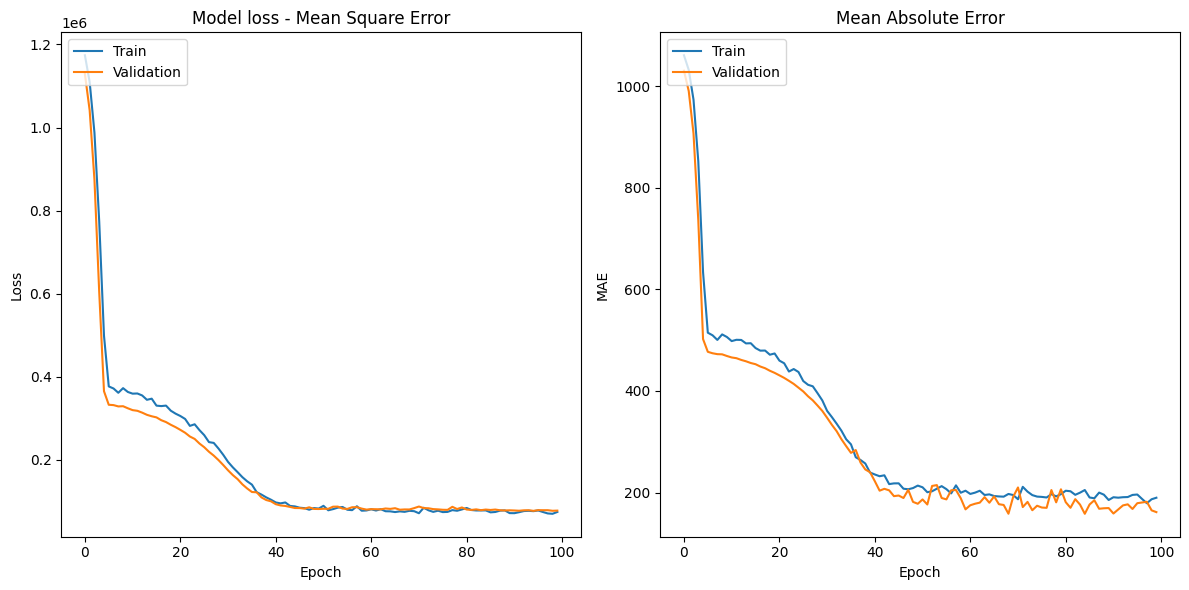

In [77]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {mae}')

# Predict the scores
predictions = model.predict(X)
# Calculate R-squared
#r2 = r2_score(y, predictions)
#print(f'R-squared: {r2}')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Mean Square Error
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Model loss - Mean Square Error')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# Plot Mean Absolute Error
axs[1].plot(history.history['mae'])
axs[1].plot(history.history['val_mae'])
axs[1].set_title('Mean Absolute Error')
axs[1].set_ylabel('MAE')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  # Adjust the padding between subplots for better layout
plt.show()

In [78]:
# Predict the scores
predictions = model.predict(X)

# Print the predictions
print(predictions)

33/33 [==============================] - 0s 786us/step
[[1151.0165]
 [ 974.4905]
 [1055.8079]
 ...
 [ 985.9794]
 [1202.272 ]
 [1100.5616]]


#### With PyTorch

In [21]:
# Import packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [35]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train,dtype=torch.float32)
X_test_tensor = torch.tensor(X_test,dtype=torch.float32)
y_train_tensor = torch.tensor(y_train,dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test,dtype=torch.float32).view(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(844, 6)


In [36]:
# Define the neural network model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate the model
input_dim = X_train.shape[1]
model = RegressionModel(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/Users/agathevianeyliaud/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
# Training loop
num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)
    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')


In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    test_mae = mean_absolute_error(y_test, predictions)
    print(f'Test MAE: {test_mae}')

# Plotting training and validation loss
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Mean Square Error
axs[0].plot(train_losses)
axs[0].plot(val_losses)
axs[0].set_title('Model loss - Mean Square Error')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# Mean Absolute Error plot can be skipped because we did not compute it during training for simplicity

plt.tight_layout()  # Adjust the padding between subplots for better layout
plt.show()

# Predict the scores
with torch.no_grad():
    predictions = model(torch.tensor(X, dtype=torch.float32)).numpy()

# Print the predictions
print(predictions)

In [27]:
X_train.shape

(844, 6)

### Random Forest

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=1)
random_search.fit(X_train_scaled, y_train)

# Best model
best_rf_model = random_search.best_estimator_

/Users/agathevianeyliaud/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
140 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/agathevianeyliaud/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/agathevianeyliaud/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/agathevianeyliaud/opt/anaconda3/envs/tensorfl

In [90]:
# Evaluate the best model on the training data
train_r2_score = best_rf_model.score(X_train_scaled, y_train)
print(f"Training R-squared value: {train_r2_score}")

# Evaluate the best model on the testing data
test_r2_score = best_rf_model.score(X_test_scaled, y_test)
print(f"Testing R-squared value: {test_r2_score}")

# Predict the scores on the testing set
y_pred = best_rf_model.predict(X_test_scaled)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Determine the top 10 athletes based on predicted scores
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=X_test.index)

Training R-squared value: 0.42525230315440943
Testing R-squared value: 0.08509192755609218
Mean Squared Error: 44861.835141130825


In [91]:
# Sort by predicted score in descending order and get the top 10
top_10_athletes = test_results.sort_values(by='Predicted', ascending=False).head(10)

result_RF = pd.DataFrame(
    {
        "Rank": df.loc[top_10_athletes.index, 'Rank'],
        "Top_10_athlete":  df.loc[top_10_athletes.index, 'Athlete'],
        "Actual score": top_10_athletes['Actual'],
        "Predicted score": top_10_athletes['Predicted']
    }
)
print(result_RF)

      Rank        Top_10_athlete  Actual score  Predicted score
1856    50          John HEYMANS        1250.0      1194.371378
1358    51           Joe KLECKER        1240.0      1193.965826
1920    26           Olin HACKER        1229.0      1190.472078
1441    35           Mike FOPPEN        1219.0      1187.934375
26       1        Yomif KEJELCHA        1288.0      1182.976473
184      8  Telahun Haile BEKELE        1274.0      1182.401269
3211    12        Sebastian FREY        1171.0      1178.889506
102     66       Hagos GEBRHIWET        1296.0      1170.903527
1878    25         Oscar CHELIMO        1208.0      1169.666268
1306    30       Morgan MCDONALD        1235.0      1166.730867
